Import the data from Edge Impulse. You can obtain the URL from the Dashboard, right-click on the download icon next to 'Spectral features data' and 'Spectral features labels', and click **Copy link location**.

In [1]:
import numpy as np
import requests

API_KEY = 'ei_a4a199d2c331dd57709baf622fca6b83528f34504943bad629b613d38a1e4b17'

X = (requests.get('https://studio.edgeimpulse.com/v1/api/3973/training/7/x', headers={'x-api-key': API_KEY})).content
Y = (requests.get('https://studio.edgeimpulse.com/v1/api/3973/training/7/y', headers={'x-api-key': API_KEY})).content

Store the data in a temporary file, and load it back through Numpy.

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

Define our labels and split the data up in a test and training set:

In [3]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_random_seed(RANDOM_SEED)

classes_values = [ "cough", "no_cough" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def set_batch_size(batch_size, train_dataset, validation_dataset):
    shuffle_buffer_size = batch_size * 3
    train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size, drop_remainder=True).prefetch(1)
    validation_dataset = validation_dataset.shuffle(shuffle_buffer_size).batch(batch_size, drop_remainder=True).prefetch(1)
    return train_dataset, validation_dataset

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)


C:\Users\digvi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\digvi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\digvi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\digvi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# Train the model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, SeparableConv1D, Reshape, MaxPooling1D, AveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
# model architecture
model = Sequential()
model.add(InputLayer(input_shape=(input_length, ), name='x_input'))
model.add(Reshape((int(input_length / 13), 13), input_shape=(input_length, )))
model.add(Conv1D(30, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=5, padding='same'))
model.add(SeparableConv1D(10, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=5, padding='same'))
model.add(Flatten())
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999)

# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 1
train_dataset, validation_dataset = set_batch_size(BATCH_SIZE, train_dataset, validation_dataset)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, verbose=2, callbacks=[callbacks])


Epoch 1/200
550/550 - 1s - loss: 0.7723 - acc: 0.3564 - val_loss: 0.7230 - val_acc: 0.3163
Epoch 2/200
550/550 - 1s - loss: 0.6992 - acc: 0.4364 - val_loss: 0.6854 - val_acc: 0.4898
Epoch 3/200
550/550 - 1s - loss: 0.6683 - acc: 0.5964 - val_loss: 0.6633 - val_acc: 0.6122
Epoch 4/200
550/550 - 1s - loss: 0.6461 - acc: 0.6527 - val_loss: 0.6439 - val_acc: 0.6224
Epoch 5/200
550/550 - 1s - loss: 0.6272 - acc: 0.6582 - val_loss: 0.6251 - val_acc: 0.6224
Epoch 6/200
550/550 - 1s - loss: 0.6096 - acc: 0.6582 - val_loss: 0.6070 - val_acc: 0.6224
Epoch 7/200
550/550 - 1s - loss: 0.5931 - acc: 0.6618 - val_loss: 0.5895 - val_acc: 0.6327
Epoch 8/200
550/550 - 1s - loss: 0.5772 - acc: 0.6745 - val_loss: 0.5731 - val_acc: 0.6429
Epoch 9/200
550/550 - 1s - loss: 0.5624 - acc: 0.6782 - val_loss: 0.5582 - val_acc: 0.6531
Epoch 10/200
550/550 - 1s - loss: 0.5485 - acc: 0.6873 - val_loss: 0.5443 - val_acc: 0.6735
Epoch 11/200
550/550 - 1s - loss: 0.5353 - acc: 0.7182 - val_loss: 0.5313 - val_acc: 0.82

# Visualizations

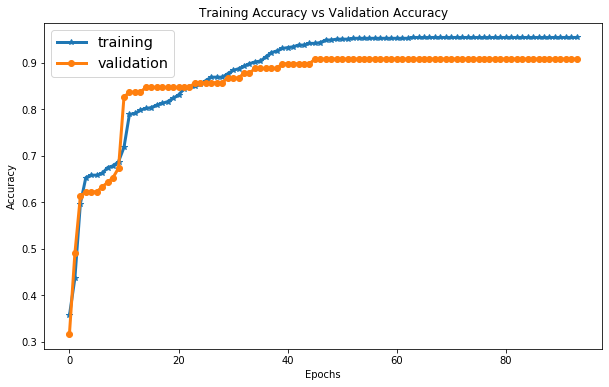

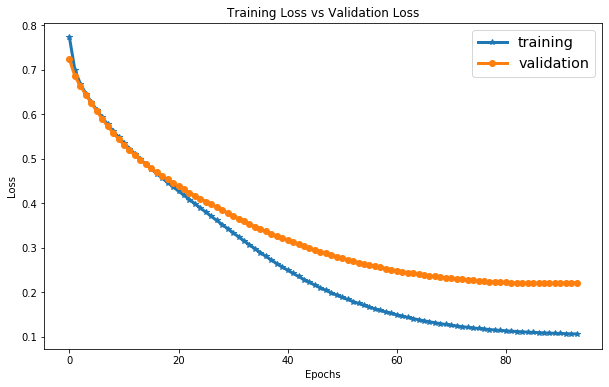

In [5]:
import matplotlib.pyplot as plt
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['acc'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_acc'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)

In [6]:
# Save the model to disk
model.save('saved_model')

# Predictions and Classification Report

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

predictions = model.predict(validation_dataset)
predictions[0:6]

array([[3.9478734e-02, 9.6052128e-01],
       [4.6643987e-03, 9.9533564e-01],
       [9.9993122e-01, 6.8793372e-05],
       [1.0000000e+00, 9.1287857e-09],
       [7.6366824e-01, 2.3633170e-01],
       [1.0000000e+00, 8.2650589e-09]], dtype=float32)

In [8]:
predicted_class_indices=np.argmax(predictions,axis=1)
predicted_class_indices

array([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1], dtype=int64)